In [7]:
using Pkg; Pkg.activate("./"); Pkg.instantiate();
using TimeseriesSurrogates, Plots, Distributions, DynamicalSystems; gr()

  Activating project at `~/Documents/Git/causalitytools/TimeseriesSurrogates.jl/notebook`


Plots.GRBackend()

In this notebook, we compute the mean time to generate a single surrogate for each of the methods implemented in TimeseriesSurrogates.jl at the time of submission to JOSS. 

We'll use the same test signal as in Lancaster et al, and generate a 5000-pt long time series with additive noise from a normal distribution with zero mean and standard deviation 0.3.

In [47]:
f(t) = sin(2π*(t + 0.5*sin(2π*t/10))/3)

f (generic function with 1 method)

In [48]:
dt = 0.1
npts = 5000
t = 0.0:dt:(npts-1)*dt
x = f.(t);
# Add some noise to the signal.
x .+= rand(Normal(0, 0.3), npts); 

In [55]:
using DelimitedFiles
writedlm( "data.csv",  x, ',')

## Average time to generate surrogates from pre-initialized `SurrogateGenerators`.

In [10]:
# Shuffle based surrogates
rs = surrogenerator(x, RandomShuffle())
bs = surrogenerator(x, BlockShuffle(10)) # 10 blocks
cs = surrogenerator(x, CycleShuffle())

# Pseudoperiodic surrogates (PPS) 
τ = estimate_delay(x, "ac_min")
d = findmin(delay_fnn(x, τ))[2]
ρ = noiseradius(x, d, τ, 0.025:0.025:0.5)
pps = surrogenerator(x, PseudoPeriodic(d, τ, ρ, true))

# Phase surrogates
rp = surrogenerator(x, RandomFourier(true))
aaft = surrogenerator(x, AAFT())
iaaft = surrogenerator(x, IAAFT())

# Truncated phase surrogates (randomize 95% highest freqs, retain 5% lowest freqs)
tfts = surrogenerator(x, TFTS(0.05))
taaft = surrogenerator(x, TAAFT(0.05))

# Wavelet surrogates
wl_aaft = surrogenerator(x, WLS(AAFT(), true))
wl_iaaft = surrogenerator(x, WLS(IAAFT(), true))
wl_rs = surrogenerator(x, WLS(RandomShuffle(), true))
wl_bs = surrogenerator(x, WLS(BlockShuffle(10), true))
wl_rp = surrogenerator(x, WLS(RandomFourier(true), true));

# Collect surrogate generators and run once to trigger precompilation
surrogens = [rs, bs, cs, pps, rp, aaft, iaaft, tfts, taaft, wl_aaft, wl_iaaft, wl_rs, wl_bs, wl_rp];
[s() for s in surrogens];

# Define labels for plot.
methods = ["RandomShuffle()" "BlockShuffle(10)" "CycleShuffle()" "PseudoPeriodic()" "RandomFourier(true)" "AAFT()" "IAAFT()" "TFTS(0.05)" "TAAFT(0.05)" "WLS(AAFT)" "WLS(IAAFT)" "WLS(RandomShuffle()" "WLS(BlockShuffle())" "WLS(RandomFourier(true))"];

Define some functions that run the benchmarks for us. We'll just use the basic `@elapsed` macro. For more precise timings, use BenchmarkTools.jl.

In [12]:
function generate_surrs(surrogenerator, n)
    for i = 1:n
        surrogenerator()
    end
end

"""
    time_n(methods; n = 100)

Compute `n` surrogates using each pre-initialized `Surrogenerator` in `methods` and compute the 
mean time to generate a surrogate.
"""
function time_n(methods; n = 100)
    benchmarks = zeros(length(methods))
    for (i, surrogen) in enumerate(methods)
        benchmarks[i] = @elapsed generate_surrs(surrogen, n)
    end
    
    return benchmarks ./ n
end
time_n(surrogens, n = 1);

In [16]:
timings = time_n(surrogens, n = 30); 

Plot the results.

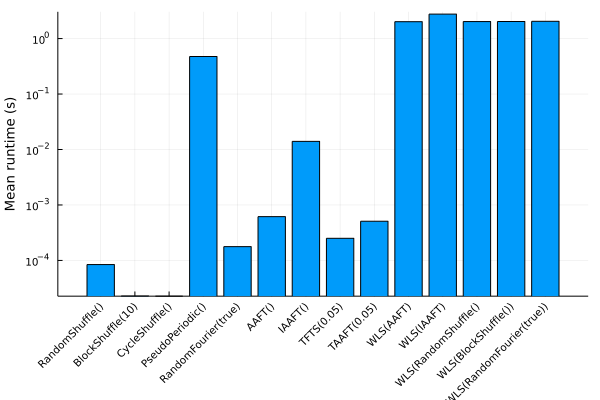

In [19]:
n_methods = length(surrogens)

plot()
bar!(1:length(timings), timings,
    ylims = (minimum(timings), min(maximum(timings), 10^2)*1.1),
    yaxis = :log10, 
    xlabel = "Number of surrogates", 
    ylabel = "Mean runtime (s)",
    xticks = (1:n_methods, methods),
    yticks = [10.0^i for i = -4:2],
    xrotation = 45,
    label = "",
    xtickfont = font(7),
    ytickfont = font(7),
    guidefont = font(9)
)

In [20]:
savefig("mean_times_in_seconds.png")

In [25]:
# Mean time for 
t_aaft = timings[6]
t_iaaft = timings[7]
t_pps = timings[4]

t_aaft, t_iaaft, t_pps

(0.0006152220666666667, 0.014016834433333332, 0.4744213161333333)